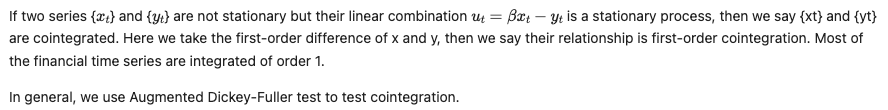

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [65]:
stocks = ['SOXL','FNGU']
start = '2020-12-31'
end  = '2023-06-15'
fee = 0.001
window = 252
t_threshold = -2.5

data = pd.DataFrame()
returns = pd.DataFrame()

for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True)-1,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [66]:
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]

for t in range(window, len(data)):
    #defining unit root function for optimization: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t]) #rolling window, lenth = window
        fair_value = a + b*data[stock1][t-window:t]
        spread = np.array(fair_value - data[stock2][t-window:t]) #model - real
        spread_diff = spread[1:] - spread[:-1] #test unit root for spread
        reg = sm.OLS(spread_diff, spread[:-1]) #dicker fuller
        res = reg.fit()
        return res.params[0]/res.bse[0] #coefficient/standard error, DF t-stats
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method = "Nelder-Mead")
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt*data[stock1][t]
    
    if t == window: #start trading
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t]) #if >0,1; if 0,0; if <0,-1
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
    fees = fee * abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    
    print('day' + str(data.index[t]))
    print(' ')
    if signal == 0:
        print('no trades')
    elif signal == 1:
        print('long ' + stock2 + ' short ' + stock1)
    else:
        print('long ' + stock1 + ' short ' + stock2)
    
    print('gross daily return: ' + str(round(gross_return*100,2))+'%')
    print('net daily return: ' + str(round(net_return*100,2))+'%')
    print('cumulative net return so far: ' + str(round(np.prod(1+net_returns)*100 - 100,2))+'%')
    
    old_signal = signal #for calculating fees

day2021-12-31 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%
day2022-01-03 00:00:00
 
long SOXL short FNGU
gross daily return: 3.52%
net daily return: 3.42%
cumulative net return so far: 3.42%
day2022-01-04 00:00:00
 
long FNGU short SOXL
gross daily return: 0.08%
net daily return: -0.12%
cumulative net return so far: 3.29%
day2022-01-05 00:00:00
 
long FNGU short SOXL
gross daily return: -0.58%
net daily return: -0.58%
cumulative net return so far: 2.69%
day2022-01-06 00:00:00
 
long FNGU short SOXL
gross daily return: 6.93%
net daily return: 6.93%
cumulative net return so far: 9.81%
day2022-01-07 00:00:00
 
no trades
gross daily return: 0%
net daily return: -0.1%
cumulative net return so far: 9.7%
day2022-01-10 00:00:00
 
long FNGU short SOXL
gross daily return: -1.01%
net daily return: -1.11%
cumulative net return so far: 8.48%
day2022-01-11 00:00:00
 
long FNGU short SOXL
gross daily return: 1.6%
net daily return: 1.6%
cumulati

day2022-04-18 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-19 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-20 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-21 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-22 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-25 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-26 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-27 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-04-28 00:00:00
 
no trades
gross daily return: 0

day2022-07-29 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-01 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-02 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-03 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-04 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-05 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-08 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-09 00:00:00
 
no trades
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 22.64%
day2022-08-10 00:00:00
 
no trades
gross daily return: 0

day2022-11-11 00:00:00
 
long FNGU short SOXL
gross daily return: 3.38%
net daily return: 3.38%
cumulative net return so far: 19.41%
day2022-11-14 00:00:00
 
long FNGU short SOXL
gross daily return: 1.23%
net daily return: 1.23%
cumulative net return so far: 20.88%
day2022-11-15 00:00:00
 
long FNGU short SOXL
gross daily return: 6.48%
net daily return: 6.48%
cumulative net return so far: 28.71%
day2022-11-16 00:00:00
 
long FNGU short SOXL
gross daily return: -1.74%
net daily return: -1.74%
cumulative net return so far: 26.47%
day2022-11-17 00:00:00
 
long FNGU short SOXL
gross daily return: -5.59%
net daily return: -5.59%
cumulative net return so far: 19.4%
day2022-11-18 00:00:00
 
long FNGU short SOXL
gross daily return: -1.09%
net daily return: -1.09%
cumulative net return so far: 18.09%
day2022-11-21 00:00:00
 
long FNGU short SOXL
gross daily return: -4.61%
net daily return: -4.61%
cumulative net return so far: 12.65%
day2022-11-22 00:00:00
 
long FNGU short SOXL
gross daily retu

day2023-02-17 00:00:00
 
long FNGU short SOXL
gross daily return: 1.62%
net daily return: 1.62%
cumulative net return so far: 82.17%
day2023-02-21 00:00:00
 
long SOXL short FNGU
gross daily return: -1.79%
net daily return: -1.99%
cumulative net return so far: 78.54%
day2023-02-22 00:00:00
 
long SOXL short FNGU
gross daily return: 3.3%
net daily return: 3.3%
cumulative net return so far: 84.43%
day2023-02-23 00:00:00
 
long SOXL short FNGU
gross daily return: 1.12%
net daily return: 1.12%
cumulative net return so far: 86.49%
day2023-02-24 00:00:00
 
long SOXL short FNGU
gross daily return: -3.18%
net daily return: -3.18%
cumulative net return so far: 80.57%
day2023-02-27 00:00:00
 
long SOXL short FNGU
gross daily return: 0.74%
net daily return: 0.74%
cumulative net return so far: 81.9%
day2023-02-28 00:00:00
 
long SOXL short FNGU
gross daily return: 3.9%
net daily return: 3.9%
cumulative net return so far: 88.99%
day2023-03-01 00:00:00
 
long SOXL short FNGU
gross daily return: 4.95

day2023-05-23 00:00:00
 
long SOXL short FNGU
gross daily return: -6.16%
net daily return: -6.16%
cumulative net return so far: 96.87%
day2023-05-24 00:00:00
 
long SOXL short FNGU
gross daily return: 12.2%
net daily return: 12.2%
cumulative net return so far: 120.89%
day2023-05-25 00:00:00
 
no trades
gross daily return: 0%
net daily return: -0.1%
cumulative net return so far: 120.67%
day2023-05-26 00:00:00
 
long FNGU short SOXL
gross daily return: 4.61%
net daily return: 4.51%
cumulative net return so far: 130.61%
day2023-05-30 00:00:00
 
long SOXL short FNGU
gross daily return: -4.97%
net daily return: -5.17%
cumulative net return so far: 118.7%
day2023-05-31 00:00:00
 
long SOXL short FNGU
gross daily return: -0.92%
net daily return: -0.92%
cumulative net return so far: 116.69%
day2023-06-01 00:00:00
 
long SOXL short FNGU
gross daily return: -2.78%
net daily return: -2.78%
cumulative net return so far: 110.67%
day2023-06-02 00:00:00
 
long SOXL short FNGU
gross daily return: -6.5

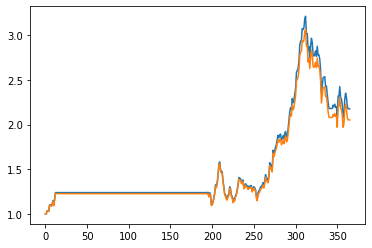

In [67]:
plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+net_returns)))